## Convolutional Neural Network (CNN)
Your task is to build and train convolutional neural networks (CNN).

If you want to use GPU, google collab provides one gpu for free. For that you will need to import this notebook into google collab. Make sure that you transfer all your data and model to GPU. After completing the assignment, you can export the file back to Jupyter Notebook, 


**Libraries allowed**: Basic python, numpy, matplotlib, and **PyTorch**.

**Note**: Submit the jupyter notebook and its pdf export. Before uploading to Canvas, make sure that all commands in your jupyter notebook are executed, and outputs, plots, and figures are visible.

** Install torchvision if you haven't already.**

In [146]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image

In [147]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

## Constants
Provide your student id and then run the cell to set values for $m$, $n$, and $p$, which are referenced later in the network configuration.

In [148]:
student_id = 771759

import re
mt = re.search(r".*(\d)(\d)(\d)", str(student_id)) 
m = int(mt.group(1))+2
n = int(mt.group(2))+3
p = int(mt.group(3))+1
print(m,n,p)

9 8 10


# Dataset 
a) Download SoCal dataset from Kaggle
https://www.kaggle.com/datasets/nisarahmedrana/biq2021.

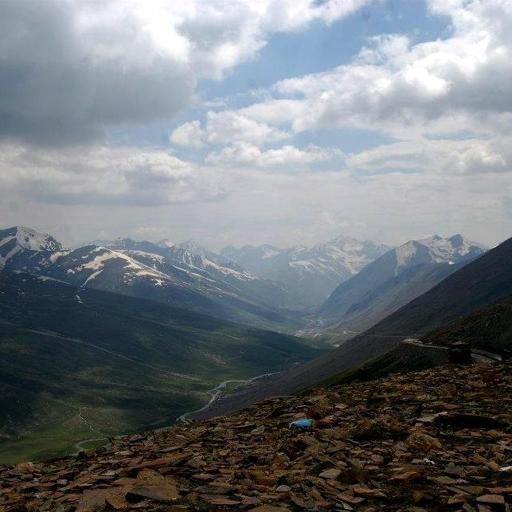

In [149]:
image_dataset = ImageFolder(root=r"C:\Users\dataset\Images\train_data")
image_dataset[2332][0]

b) Calculate the mean and standard deviation of the training images.

In [150]:
#Designed a Transform to convert Training Images to Tensors only
training_data_transforms_for_mean_std = transforms.Compose([transforms.ToTensor()])                             

In [151]:
#Conversion of Training Image dataset to Tensors
training_dataset = ImageFolder(root=r"C:\Users\dataset\Images\train_data",
                        transform=training_data_transforms_for_mean_std)

In [152]:
mean = 0.0
for img, _ in training_dataset:
    mean += img.mean([1,2])
mean = mean/len(training_dataset)
print(mean)

tensor([0.4711, 0.4478, 0.4161])


In [58]:
sumel = 0.0
countel = 0
for img, _ in training_dataset:
    img = (img - mean.unsqueeze(1).unsqueeze(1))**2
    sumel += img.sum([1, 2])
    countel += torch.numel(img[0])
std = torch.sqrt(sumel/countel)
print(std)

tensor([0.2997, 0.2879, 0.2965])


c) Implement the custom dataset class for training and test. 
For training, do the following transforms: 
 - resize the images to 32 by 32. 
 - Randomly flip images from left to right and 
 - then Normalize with the mean and std. dev. obtained in step b.
 
For testing, resize to 32 by 32 and normalize.

(i) In the init method, store the path to the images and labels. You can use any data structure of your choice, e.g., list/nested list, dictionary, or pandas dataframe.

(ii) in the getitem method, use the path stored at position ``idx`` to load the image. Return image and its qualitt. 

In [153]:
#Desigining a Transform for Training dataset
training_data_transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((32,32)),
                                
                                # NOTE:
                                # transforms.fliplr(training_set), as Input is not a single 2D array its a set of images in a
                                # tensor form, so Flipping from Left to Right give error: not possible, so only Horizontal or Vertical flip-
                                # possible, so Horizontal Flip is selected here
                                
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((mean), (std)) 
                               ])

In [154]:
#Transform for Test dataset
test_data_transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((32,32)),
                                transforms.Normalize((mean), (std)) 
                               ])

In [155]:
import pandas as pd
root_dir = pd.read_csv(r"C:\Users\dataset\Train_images.csv")
df = pd.DataFrame(root_dir)
df.head(5)

,Image Name,MOS,Unnamed: 2,Unnamed: 3
0,ss03 (3753).jpg,0.8471,NaN,NaN
1,ss01 (1726).jpg,0.2874,NaN,NaN
2,ss03 (5905).jpg,0.7314,NaN,NaN
3,ss03 (961).jpg,0.6596,NaN,NaN
4,ss03 (5215).jpg,0.7628,NaN,NaN


In [156]:
class HousingDataset(Dataset):
    def __init__(self, root_dir, training = True, transform=None): # Here root_dir is the path to train or test folder.
        # coomplete this method as per instructions
        # Storing path of images and labels
        self.root_dir = root_dir
        self.training = training
        self.transform = transform
        self.image_paths, self.labels = self.load_data()
        
        def load_data(self):
            if self.training:
            # Loading training data CSV file 
                training_data = pd.read_csv(r"C:\Users\dataset\Train_images.csv") 
            else:
            # Loading test data CSV file 
                test_data = pd.read_csv(r"C:\Users\dataset\Test_images.csv")  

            image_paths = data['Image Name'].tolist()  
            labels = data['MOS'].tolist()  
            return image_paths, labels
        
        if training == True:
            self.transform = None
        else:
            self.transform = None
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        #loading images and performing some transformatoins
        image_path = self.image_paths[idx]
        label_price = self.labels[idx]
        # Loading images
        image = Image.open(image_path)
        return image, label_price


d) Instantiate training and test datasets.

In [157]:
#Conversion of Training Image dataset to Tensors
training_dataset = ImageFolder(root=r"C:\Users\dataset\Images\train_data",
                        transform=training_data_transforms)                       

In [158]:
#Conversion of Test Image dataset to Tensors
test_dataset = ImageFolder(root=r"C:\Users\dataset\Images\test_data",
                            transform=test_data_transforms)                          

e) Partition the training dataset into training and validation. 10% of training images are validation. Configure the dataloaders with batch size of 16.

In [159]:
print(len(training_dataset))  #Total images in Training dataset

9600


In [160]:
#dividing training_dataset into 90% (8640 images) training set, 10% (960 images) validation set
training_set, validation_set = torch.utils.data.random_split(training_dataset, [8640, 960])
print(len(training_set))
print(len(validation_set))

8640
960


In [161]:
train_loader = DataLoader(training_set   , batch_size= 16, shuffle=True)
val_loader   = DataLoader(validation_set , batch_size= 16, shuffle=True)
test_loader  = DataLoader(test_dataset   , batch_size= 16, shuffle=True)

e) Visualize two random training images.

In [38]:
training_set[0][0]

tensor([[[ 0.1795, -1.0947, -0.9120,  ..., -2.6634, -2.8055, -2.6938],
         [-1.0186, -0.6328, -1.3993,  ..., -2.3131, -2.8207, -2.7801],
         [-1.2115, -1.1810, -1.6328,  ..., -3.0086, -2.8512, -3.0542],
         ...,
         [-1.5922, -1.4298, -1.6277,  ..., -2.8258, -2.9070, -2.9019],
         [-1.4044, -1.1607, -1.7902,  ..., -2.9375, -2.9121, -2.8664],
         [-1.5414, -1.2318, -2.6430,  ..., -2.9730, -2.7953, -2.9121]],

        [[ 0.4841, -0.0743,  0.1033,  ..., -2.2877, -2.4908, -2.1506],
         [ 0.0475, -0.0947, -0.3586,  ..., -1.8714, -2.7141, -2.3334],
         [-0.3180, -0.4449, -0.9120,  ..., -2.9679, -2.6989, -2.6329],
         ...,
         [-1.1201, -0.9221, -1.1099,  ..., -2.0643, -2.1456, -2.2319],
         [-0.7343, -0.6125, -1.4095,  ..., -2.1862, -2.0593, -2.1202],
         [-0.9120, -0.6683, -2.4095,  ..., -2.2319, -2.0948, -2.2166]],

        [[-1.6277, -1.1303, -1.8663,  ..., -3.3233, -2.8004, -2.8309],
         [-2.0389, -2.1456, -1.7191,  ..., -2

In [39]:
training_set[200][0]

tensor([[[ 1.3217,  1.7177,  1.5603,  ...,  0.9003,  0.8851,  0.8597],
         [ 1.3521,  1.8243,  1.5044,  ...,  0.8800,  0.8851,  0.8140],
         [ 1.3826,  1.6009,  1.3115,  ...,  0.8800,  0.8597,  0.8242],
         ...,
         [ 1.0476,  1.1136,  0.6161,  ...,  0.9156,  0.4739,  0.5551],
         [ 0.8851,  0.8343,  0.8293,  ...,  0.5602,  0.4587,  0.5754],
         [ 1.4131,  0.8039,  0.6516,  ...,  0.8343,  0.8547,  0.4384]],

        [[ 0.9511,  1.3725,  1.2151,  ...,  0.3521,  0.3165,  0.3115],
         [ 0.9663,  1.4943,  1.1795,  ...,  0.3318,  0.3165,  0.2658],
         [ 1.0425,  1.2862,  0.9511,  ...,  0.3318,  0.3115,  0.2759],
         ...,
         [ 0.0729,  0.2201, -0.3789,  ..., -0.0794, -0.5211, -0.4195],
         [-0.0084, -0.0490, -0.1048,  ..., -0.4957, -0.5160, -0.5769],
         [ 0.5298, -0.2469, -0.3231,  ..., -0.1606, -0.0794, -0.5769]],

        [[ 0.5501,  0.8547,  0.6059,  ...,  0.1287,  0.0932,  0.0881],
         [ 0.6414,  0.8800,  0.5095,  ...,  0

# Q1. CNN
a) Build a NN network specified in the figure below and initialize the parameters. 

The network consists of:
1. Residual block 1: first layer has $m$ number of 3x3 filters with stride=1 and RelU activation function and second layer has m number of 3x3 filters. 
2. Residual block 2: first layer has $n$ number of 3x3 filters with stride=2 and RelU activation function and second layer has m number of 3x3 filters.
3. FC layer with $p$ neurons.
4. output layer.


Note: Design the convolution filters, if necessary, to match the output volume size of a residual block to that of input. Also, select padding such that output size is an integer division of input size.Use residual block from ResNet18 as a reference.


In [162]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        return out

class CNN(nn.Module):
    def __init__(self, m, n, p, num_classes):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, m, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(m)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.residual_block1 = ResidualBlock(m, m, stride=1)
        self.residual_block2 = ResidualBlock(m, n, stride=2)
        
        self.fc = nn.Linear(n, p)
        
        self.output_layer = nn.Linear(p, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        
        # pooling
        x = torch.mean(x, dim=[2, 3])
        
        x = self.fc(x)
        x = self.relu(x)
        
        x = self.output_layer(x)
        
        return x


b) Create a model

In [168]:
num_classes = 1
cnn_model = CNN(m, n, p, num_classes)

# if you use GPU, uncomment the floolowing line
# cnn_model = cnn_model.cuda()

c) Do forward propagation for a minibatch and verify that the output shape equals the number of samples in a minibatch by the number of classes.

In [169]:
data,labels = next(iter(train_loader))

quality_score = cnn_model(data)

print(quality_score.shape)

torch.Size([16, 1])


d) Set up the loss and optimizer. Train using Stochastic gradient descent with momentum for 50 epochs with a learning rate of 0.01, momentum of 0.9, and weight_decay of $1e-8$. 

In [172]:
# Loss function
criterion = nn.MSELoss()  

lr = 0.01 # Learning rate
epochs = 50

# Modify this op
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-8)


e) Do the training and validation. Follow the instructions in the code block to complete this part.

In [173]:
training_avg_loss = []
total_train_loss = []
total_val_loss = []
val_avg_loss = []

for epoch in range(epochs):
    # Training
    cnn_model.train()
    
    total_train_loss = 0.0
    num_train_batches = 0
    
    for batch in iter(train_loader):
        optimizer.zero_grad()
        data, target_labels = batch
        # If you are using GPU, uncomment the following line
        # data, target_labels = data.cuda(), target_labels.cuda()
        
        # Forward propagate
        prediction = cnn_model(data)
        
        # Calculate loss
        loss = torch.sqrt(criterion(prediction, target_labels.float()))  
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # combining training loss
        total_train_loss += loss.item()
        num_train_batches += 1
    
    # calculation of average training loss 
    avg_train_loss = total_train_loss / num_train_batches
    training_avg_loss.append(avg_train_loss)
   
    ###### Evaluation ####
    
    # Note, evaluation here is done after each epoch. 
    
    # During validation, we do not optimize so no need to build a computation graph for gradient. 
    # Hence, turning off gradients using torch.no_grad()
    with torch.no_grad():
        cnn_model.eval()
        
        total_val_loss = 0.0
        num_val_batches = 0
        
        for batch in iter(val_loader):
            data, target_labels = batch
            # Forward propagate
            prediction = cnn_model(data)
            # Calculate loss
            val_loss = torch.sqrt(criterion(prediction, target_labels.float()))  # Using RMSE loss
            # Combining validation loss
            total_val_loss += val_loss.item()
            num_val_batches += 1
        
        # calculation of average validation loss 
        avg_val_loss = total_val_loss / num_val_batches
        val_avg_loss.append(avg_val_loss)
    
    # Printing both loss of each epoch
    print(f'Epoch [{epoch + 1}/{epochs}], Avg Training Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}')


Epoch [1/50], Avg Training Loss: 0.7555, Avg Validation Loss: 0.7494
Epoch [2/50], Avg Training Loss: 0.7566, Avg Validation Loss: 0.7474
Epoch [3/50], Avg Training Loss: 0.7554, Avg Validation Loss: 0.7498
Epoch [4/50], Avg Training Loss: 0.7552, Avg Validation Loss: 0.7523
Epoch [5/50], Avg Training Loss: 0.7547, Avg Validation Loss: 0.7491
Epoch [6/50], Avg Training Loss: 0.7551, Avg Validation Loss: 0.7505
Epoch [7/50], Avg Training Loss: 0.7548, Avg Validation Loss: 0.7518
Epoch [8/50], Avg Training Loss: 0.7548, Avg Validation Loss: 0.7479
Epoch [9/50], Avg Training Loss: 0.7562, Avg Validation Loss: 0.7498
Epoch [10/50], Avg Training Loss: 0.7567, Avg Validation Loss: 0.7514
Epoch [11/50], Avg Training Loss: 0.7557, Avg Validation Loss: 0.7509
Epoch [12/50], Avg Training Loss: 0.7546, Avg Validation Loss: 0.7461
Epoch [13/50], Avg Training Loss: 0.7551, Avg Validation Loss: 0.7538
Epoch [14/50], Avg Training Loss: 0.7556, Avg Validation Loss: 0.7506
Epoch [15/50], Avg Training L

f) Plot losses vs epoch for training and validation datasets

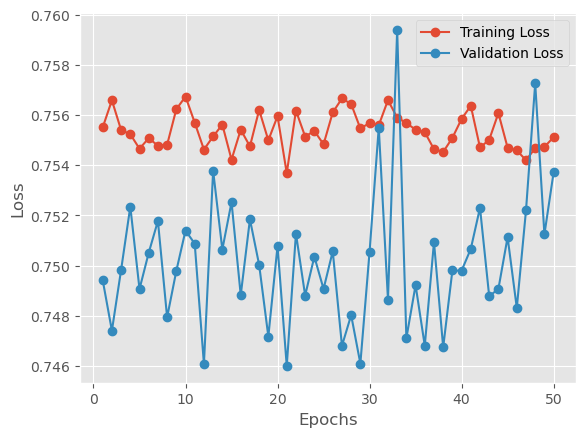

In [179]:
# plotting both losses of each epoch
plt.style.use('ggplot')

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, training_avg_loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_avg_loss, label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()  

plt.show()


g) Calculate loss and coefficient of determination ($R^2$ for test data. (https://en.wikipedia.org/wiki/Coefficient_of_determination) for the test data.

In [175]:
# your code
with torch.no_grad():
    cnn_model.eval()
    total_test_loss = 0.0
    num_test_batches = 0

    for batch in iter(test_loader):
        data, target_labels = batch
        prediction = cnn_model(data)
        test_loss = torch.sqrt(criterion(prediction, target_labels.float()))  
        total_test_loss += test_loss.item()
        num_test_batches += 1
    avg_test_loss = total_test_loss / num_test_batches



C:\Users\khalil\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\khalil\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same

In [178]:
print(avg_test_loss)

0.7535418343544006


In [177]:
#coefficient of determination 
from sklearn.metrics import r2_score
# conversion from Tensor to NumPy arrays in order to find R2 score
y_true = target_labels.numpy()  
y_pred = prediction.numpy()  

r2 = r2_score(y_true, y_pred)
print(r2)

0.006534886830817377


h) Explain the plots in question (f) and the performance measure in question (g)

1)-with respect to Visualization: abrupt behaviour, osscilations in both Training and Validation Losses but if you can focus
    on Loss or y-axis all the Training-loss is between 0.754 to 0.756, and Validation-Loss is between 0.746 to 0.756 with 
    some outliers. which means that Losses are smooth or there is not to much variation in data.
    
2)-Loss is 75.7% or it means 25% of time our model predicitions are accurate only.
3)-As value of Coefficient of determination is to small 0.0065, that means model will not performs well on test data or model 
   not learn patterns of data.
